# Naive Bayes - Glass Dataset

## Imports

In [1]:
import warnings
warnings.filterwarnings('ignore')

import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
from sklearn.naive_bayes import GaussianNB, MultinomialNB
from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import cross_validate, KFold, StratifiedKFold, cross_val_predict

from utils import evaluate_cross_validation, evaluation, evaluation_all_features, discretize_dataset, print_score

## Dataset analysis

In [2]:
path = './data/glass/glass.data'

feature_names = ['RI', 'Sodium', 'Magnesium', 'Aluminum', 'Silicon', 'Potassium', 'Calcium', 'Barium', 'Iron']
class_names = ['Building windows FP', 'Building windows NFP',
               'Vehicle windows FP', 'Vehicle windows NFP',
               'Containers', 'Tableware', 'Headlamps']
class_column_name = 'Type of glass'

names = ['Id'] + feature_names + ['y']
dataset = pd.read_csv(path, names=names)
dataset['y'] = dataset['y'].apply(lambda x: x - 1)
dataset[class_column_name] = dataset['y'].apply(lambda x: class_names[x])

In [3]:
dataset.head()

Id       RI  Sodium  Magnesium  Aluminum  Silicon  Potassium  Calcium  \
0   1  1.52101   13.64       4.49      1.10    71.78       0.06     8.75   
1   2  1.51761   13.89       3.60      1.36    72.73       0.48     7.83   
2   3  1.51618   13.53       3.55      1.54    72.99       0.39     7.78   
3   4  1.51766   13.21       3.69      1.29    72.61       0.57     8.22   
4   5  1.51742   13.27       3.62      1.24    73.08       0.55     8.07   

   Barium  Iron  y        Type of glass  
0     0.0   0.0  0  Building windows FP  
1     0.0   0.0  0  Building windows FP  
2     0.0   0.0  0  Building windows FP  
3     0.0   0.0  0  Building windows FP  
4     0.0   0.0  0  Building windows FP

In [4]:
dataset.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 214 entries, 0 to 213
Data columns (total 12 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Id             214 non-null    int64  
 1   RI             214 non-null    float64
 2   Sodium         214 non-null    float64
 3   Magnesium      214 non-null    float64
 4   Aluminum       214 non-null    float64
 5   Silicon        214 non-null    float64
 6   Potassium      214 non-null    float64
 7   Calcium        214 non-null    float64
 8   Barium         214 non-null    float64
 9   Iron           214 non-null    float64
 10  y              214 non-null    int64  
 11  Type of glass  214 non-null    object 
dtypes: float64(9), int64(2), object(1)
memory usage: 20.2+ KB


In [5]:
dataset[feature_names].describe()

RI      Sodium   Magnesium    Aluminum     Silicon   Potassium  \
count  214.000000  214.000000  214.000000  214.000000  214.000000  214.000000   
mean     1.518365   13.407850    2.684533    1.444907   72.650935    0.497056   
std      0.003037    0.816604    1.442408    0.499270    0.774546    0.652192   
min      1.511150   10.730000    0.000000    0.290000   69.810000    0.000000   
25%      1.516523   12.907500    2.115000    1.190000   72.280000    0.122500   
50%      1.517680   13.300000    3.480000    1.360000   72.790000    0.555000   
75%      1.519157   13.825000    3.600000    1.630000   73.087500    0.610000   
max      1.533930   17.380000    4.490000    3.500000   75.410000    6.210000   

          Calcium      Barium        Iron  
count  214.000000  214.000000  214.000000  
mean     8.956963    0.175047    0.057009  
std      1.423153    0.497219    0.097439  
min      5.430000    0.000000    0.000000  
25%      8.240000    0.000000    0.000000  
50%      8.600000    0.000000    0.000000  
75%      9.172500    0.000000    0.100000  
max     16.190000    3.150000    0.510000

In [6]:
dataset_numeric = dataset[feature_names]
dataset_numeric = dataset_numeric.apply(pd.to_numeric, errors='coerce')

In [7]:
dataset[dataset.isnull().any(axis=1)].head()

Empty DataFrame
Columns: [Id, RI, Sodium, Magnesium, Aluminum, Silicon, Potassium, Calcium, Barium, Iron, y, Type of glass]
Index: []

In [8]:
dataset[dataset.duplicated()].head()

Empty DataFrame
Columns: [Id, RI, Sodium, Magnesium, Aluminum, Silicon, Potassium, Calcium, Barium, Iron, y, Type of glass]
Index: []

## Dataset preprocessisng

In [9]:
dataset.dropna(inplace=True)

In [10]:
dataset.drop_duplicates(inplace=True)

In [11]:
dataset[feature_names].describe()

RI      Sodium   Magnesium    Aluminum     Silicon   Potassium  \
count  214.000000  214.000000  214.000000  214.000000  214.000000  214.000000   
mean     1.518365   13.407850    2.684533    1.444907   72.650935    0.497056   
std      0.003037    0.816604    1.442408    0.499270    0.774546    0.652192   
min      1.511150   10.730000    0.000000    0.290000   69.810000    0.000000   
25%      1.516523   12.907500    2.115000    1.190000   72.280000    0.122500   
50%      1.517680   13.300000    3.480000    1.360000   72.790000    0.555000   
75%      1.519157   13.825000    3.600000    1.630000   73.087500    0.610000   
max      1.533930   17.380000    4.490000    3.500000   75.410000    6.210000   

          Calcium      Barium        Iron  
count  214.000000  214.000000  214.000000  
mean     8.956963    0.175047    0.057009  
std      1.423153    0.497219    0.097439  
min      5.430000    0.000000    0.000000  
25%      8.240000    0.000000    0.000000  
50%      8.600000    0.000000    0.000000  
75%      9.172500    0.000000    0.100000  
max     16.190000    3.150000    0.510000

## Dataset visualization

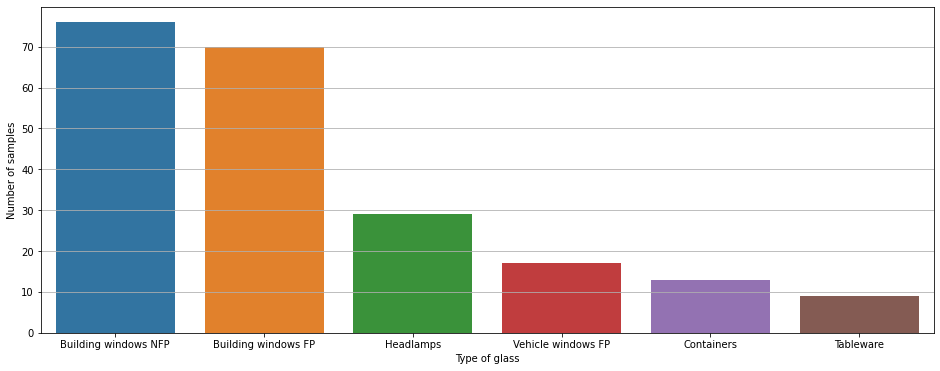

In [12]:
dataset_class_counts = dataset[class_column_name].value_counts()
plt.figure(figsize=(16, 6))
plt.grid(True)
plt.ylabel('Number of samples')
plt.xlabel(class_column_name)
sns.barplot(dataset_class_counts.index, dataset_class_counts.values)
plt.savefig('plots/glass_class_dist.png')

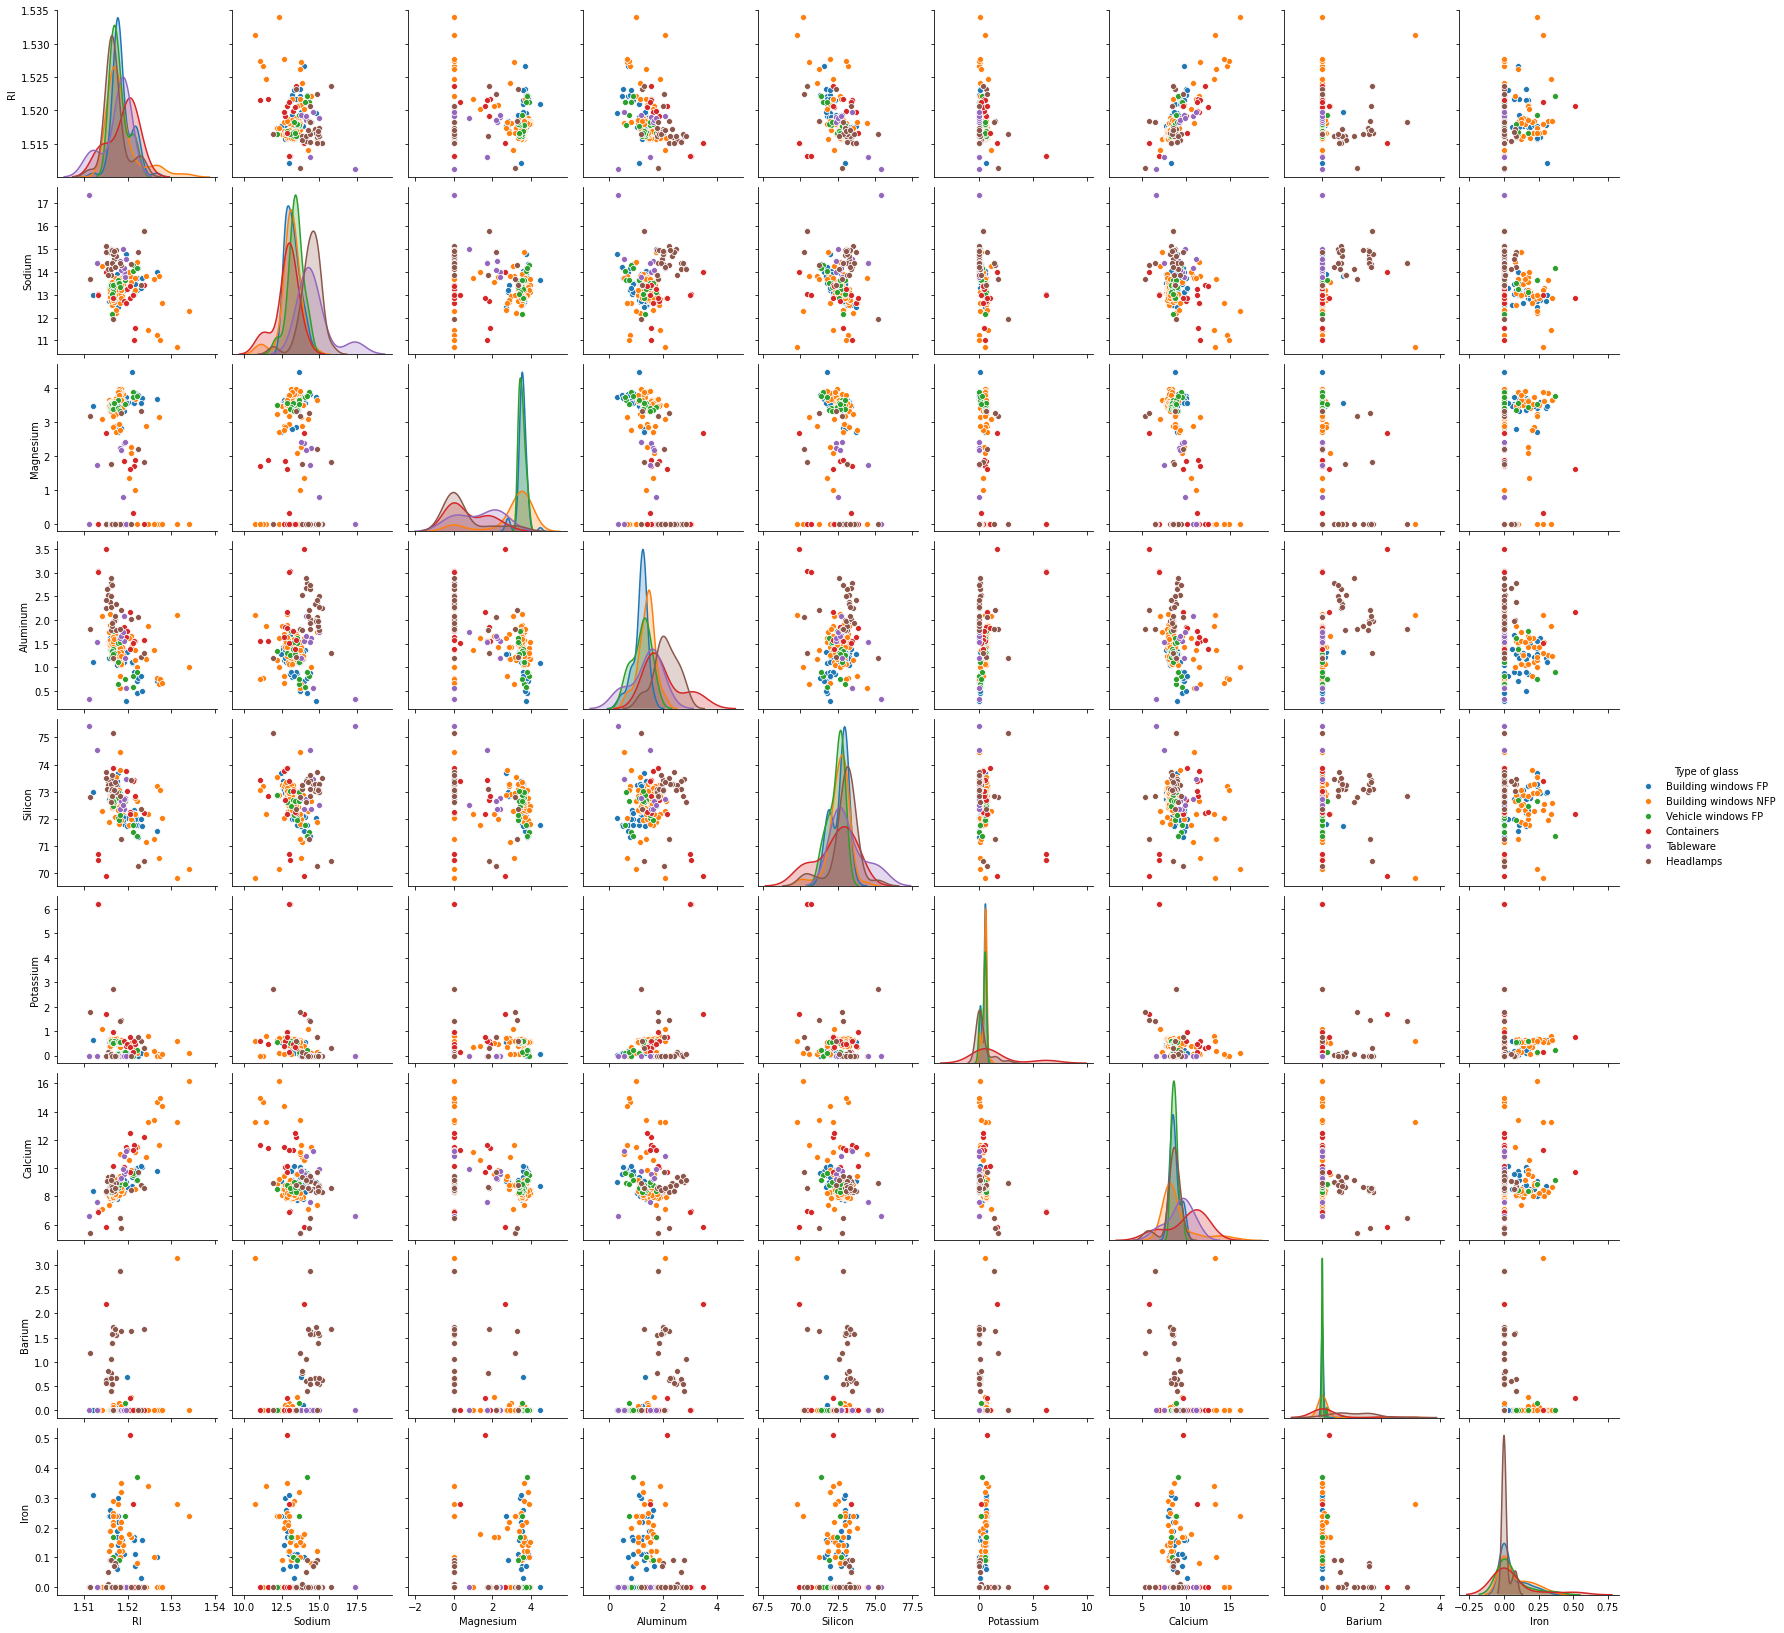

In [13]:
sns.pairplot(dataset, hue=class_column_name, vars=feature_names)
plt.savefig('plots/glass_pairplot.png')

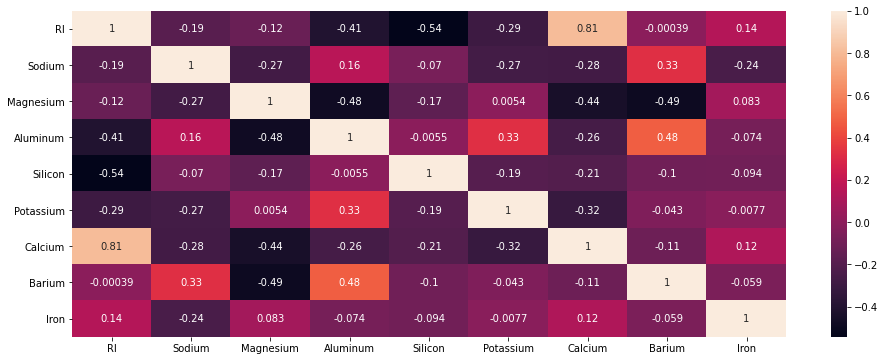

In [14]:
plt.figure(figsize=(16, 6))
sns.heatmap(dataset[feature_names].corr(), annot=True)
plt.savefig('plots/glass_correlation.png')

## Model fitting

In [15]:
X, y = dataset[feature_names], dataset['y']

model_gnb = GaussianNB()

sk_fold = StratifiedKFold(n_splits=8, random_state=3, shuffle=True)
y_pred = cross_val_predict(model_gnb, X, y, cv=sk_fold)

print_score(y, y_pred)

Acc:           0.46261682242990654
f1 avg:        0.4525600835945664
Recall avg:    0.4901762367813398
Precision avg: 0.45919125368513586
Recall:        [0.68571429 0.18421053 0.23529412 0.15384615 0.88888889 0.79310345]
Precision:     [0.46153846 0.48275862 0.12903226 0.18181818 0.61538462 0.88461538]
f1:            [0.55172414 0.26666667 0.16666667 0.16666667 0.72727273 0.83636364]
Confusion matrix:
[[48  4 17  0  1  0]
 [44 14 10  4  3  1]
 [11  1  4  0  1  0]
 [ 0  9  0  2  0  2]
 [ 0  0  0  1  8  0]
 [ 1  1  0  4  0 23]]


In [16]:
k_splits = list(range(2, 11))
results, errors = evaluate_cross_validation(model_gnb, X, y, KFold, k_splits)

_, ax = plt.subplots(figsize=(16, 6))
ax.bar(k_splits, results,
       yerr=errors,
       align='center',
       alpha=0.5,
       ecolor='black',
       capsize=10)
ax.set_ylabel('Mean F-score')
ax.set_xlabel('Number of splits')
ax.set_xticks(k_splits)
ax.set_xticklabels(k_splits)
ax.set_ylim(.3, 0.55)
ax.set_title('K-Fold')
ax.yaxis.grid(True)
plt.savefig('plots/glass_kfold_results.png')

In [17]:
k_splits = list(range(2, 11))
results, errors = evaluate_cross_validation(model_gnb, X, y, StratifiedKFold, k_splits)

_, ax = plt.subplots(figsize=(16, 6))
ax.bar(k_splits, results,
       yerr=errors,
       align='center',
       alpha=0.5,
       ecolor='black',
       capsize=10)
ax.set_ylabel('Mean F-score')
ax.set_xlabel('Number of splits')
ax.set_xticks(k_splits)
ax.set_xticklabels(k_splits)
ax.set_ylim(.3, 0.55)
ax.set_title('Stratified K-Fold')
ax.yaxis.grid(True)
plt.savefig('plots/glass_stratified_kfold_results.png')

## Discretization

In [18]:
model = MultinomialNB()
skfold = StratifiedKFold(n_splits=5, shuffle=True, random_state=3)
r = evaluation_all_features(dataset, feature_names, feature_names, class_column_name, model,
                            skfold, list(range(3, 16)), ['uniform', 'quantile', 'kmeans'])

data = pd.DataFrame(r, columns=['Number of bins', 'Strategy', 'F-score'])

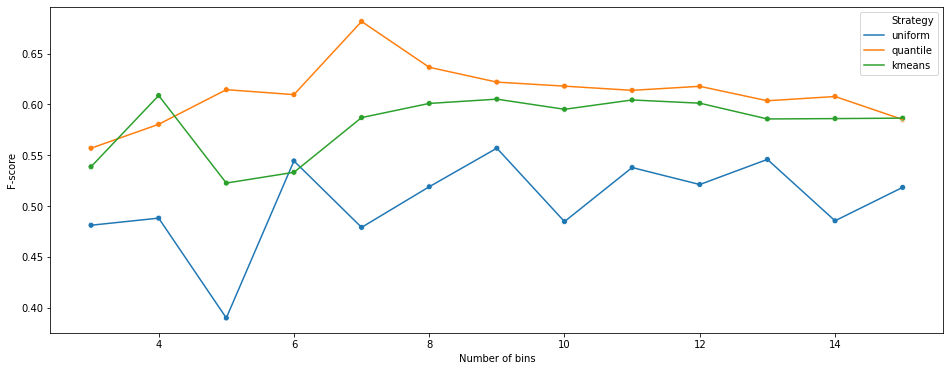

In [19]:
plt.figure(figsize=(16, 6))
sns.scatterplot(x="Number of bins", y="F-score", hue='Strategy', data=data, legend=None)
sns.lineplot(x="Number of bins", y="F-score", hue='Strategy', data=data)
plt.savefig('plots/glass_discretiztion_bin_strategy.png')

In [20]:
df = discretize_dataset(dataset, feature_names, n_bins=7, strategy='quantile')
df[feature_names].describe()

RI      Sodium   Magnesium    Aluminum     Silicon   Potassium  \
count  214.000000  214.000000  214.000000  214.000000  214.000000  214.000000   
mean     3.023364    3.023364    2.191589    3.000000    3.009346    3.060748   
std      2.017393    2.017393    1.842565    2.009368    2.004667    2.044356   
min      0.000000    0.000000    0.000000    0.000000    0.000000    0.000000   
25%      1.000000    1.000000    0.000000    1.000000    1.000000    1.000000   
50%      3.000000    3.000000    2.000000    3.000000    3.000000    3.000000   
75%      5.000000    5.000000    4.000000    5.000000    5.000000    5.000000   
max      6.000000    6.000000    5.000000    6.000000    6.000000    6.000000   

          Calcium      Barium        Iron  
count  214.000000  214.000000  214.000000  
mean     3.004673    0.144860    0.448598  
std      2.008194    0.352785    0.759709  
min      0.000000    0.000000    0.000000  
25%      1.000000    0.000000    0.000000  
50%      3.000000    0.000000    0.000000  
75%      5.000000    0.000000    1.000000  
max      6.000000    1.000000    2.000000

In [21]:
df_class_counts = df[class_column_name].value_counts()
plt.figure(figsize=(16, 6))
sns.barplot(df_class_counts.index, df_class_counts.values)
plt.savefig('plots/glass_class_dist_after_discretization.png')

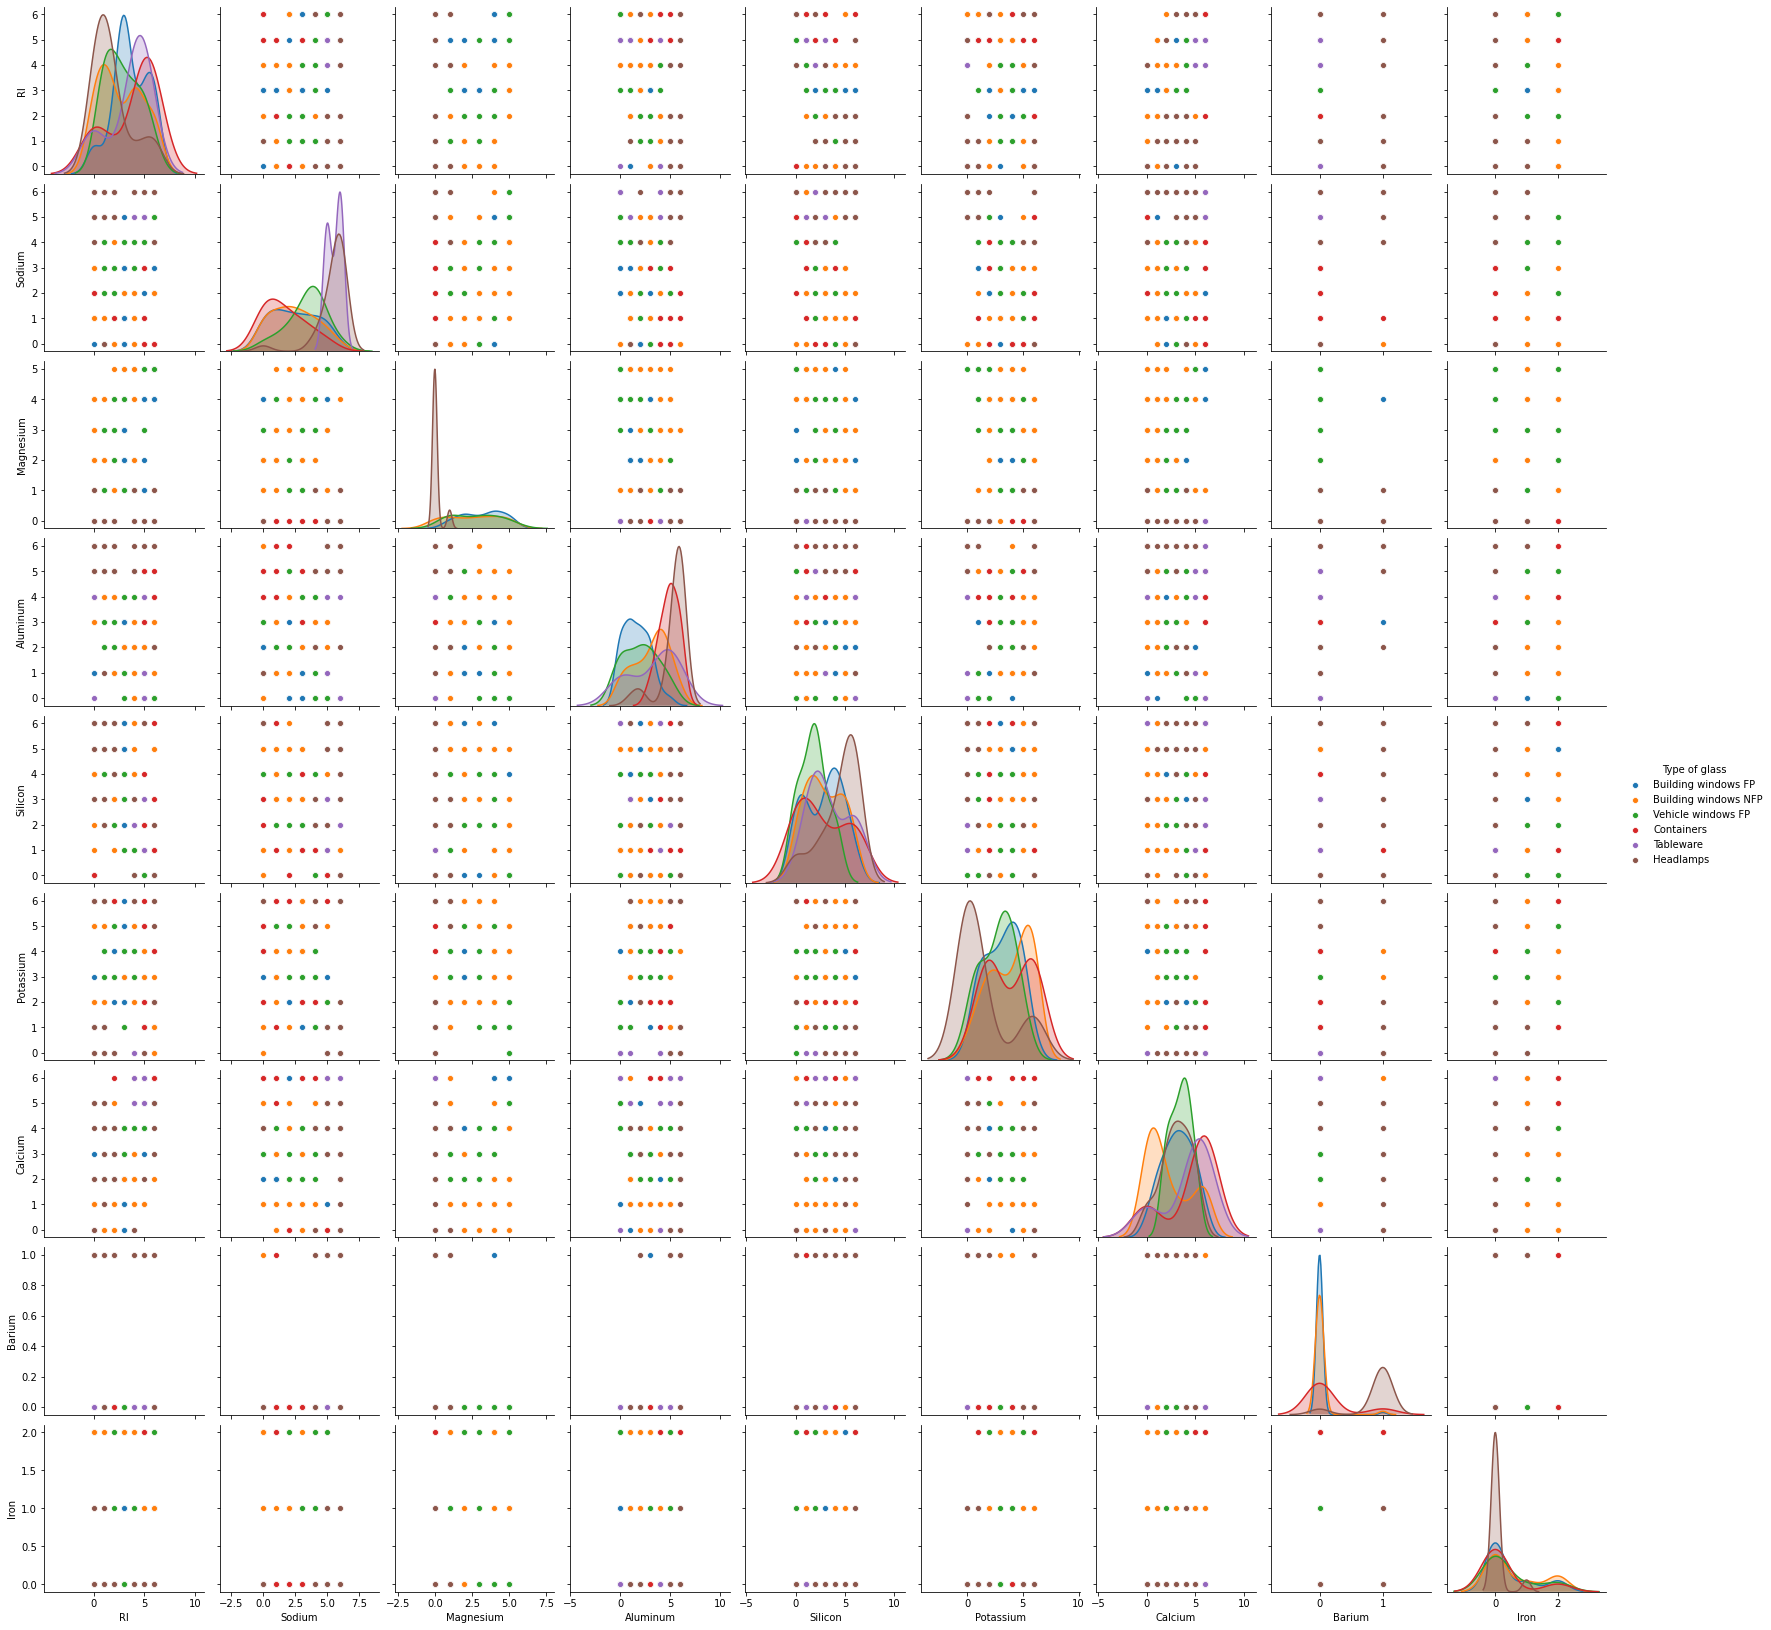

In [22]:
sns.pairplot(df, hue=class_column_name, vars=feature_names)
plt.savefig('plots/glass_pairplot_after_discretization.png')

In [23]:
X, y = df[feature_names].to_numpy(), df['y'].to_numpy()
X = OneHotEncoder().fit_transform(X)

model_mnb = MultinomialNB()

sk_fold = StratifiedKFold(n_splits=5, random_state=3, shuffle=True)
y_pred = cross_val_predict(model_mnb, X, y, cv=sk_fold)

print_score(y, y_pred)

Acc:           0.7102803738317757
f1 avg:        0.6859195407508326
Recall avg:    0.7413593079281133
Precision avg: 0.6666473093302362
Recall:        [0.81428571 0.57894737 0.23529412 0.92307692 1.         0.89655172]
Precision:     [0.69512195 0.73333333 0.4        0.6        0.64285714 0.92857143]
f1:            [0.75       0.64705882 0.2962963  0.72727273 0.7826087  0.9122807 ]
Confusion matrix:
[[57  9  4  0  0  0]
 [17 44  2  8  4  1]
 [ 7  5  4  0  1  0]
 [ 0  0  0 12  0  1]
 [ 0  0  0  0  9  0]
 [ 1  2  0  0  0 26]]


In [24]:
model = MultinomialNB()

skfold = StratifiedKFold(n_splits=5, shuffle=True, random_state=3)
r = evaluation(dataset, feature_names, feature_names, 'y', model,
               skfold, list(range(3, 16)), ['uniform', 'quantile', 'kmeans'],
               7, 'quantile', 'f1_macro')

data = pd.DataFrame(r, columns=['Feature', 'Number of bins', 'Strategy', 'F-score'])
data['Feature'] = data['Feature'].apply(lambda x: feature_names[x])

In [25]:
df = data[data['F-score'].isin(data.groupby('Feature')['F-score'].max().values)]
df.drop_duplicates(['Feature'], inplace=True)
df

Feature  Number of bins  Strategy   F-score
37          RI              15  quantile  0.689551
40      Sodium               3  quantile  0.709325
94   Magnesium               8  quantile  0.705908
137   Aluminum               9    kmeans  0.711624
175    Silicon               9  quantile  0.692104
215  Potassium               9    kmeans  0.692154
269    Calcium              14    kmeans  0.691431
281     Barium               5    kmeans  0.691140
331       Iron               9  quantile  0.701524

In [26]:
grid = sns.FacetGrid(data, col="Feature", hue='Strategy', col_wrap=3)
grid.map(plt.scatter, "Number of bins", "F-score").add_legend(bbox_to_anchor=(1, 1), loc=2, frameon=True)
grid.map(plt.plot, "Number of bins", "F-score")
grid.map(plt.axhline, y=0.6859, ls=":", c='r')
grid.fig.tight_layout(h_pad=3)
plt.savefig('plots/glass_discretization.png')

In [27]:
# df = discretize_dataset(dataset, feature_names, n_bins=[12,9,6,13,4,13,3,7,8],
#                         strategies=['quantile','uniform','quantile','uniform','quantile','kmeans','uniform','quantile','kmeans'])
df = discretize_dataset(dataset, feature_names, n_bins=[8,8,8,8,8,8,8,8,8],
                        strategy=['quantile','uniform','kmeans','quantile','quantile','kmeans','quantile','uniform','kmeans'])
df[feature_names].describe()

RI      Sodium   Magnesium    Aluminum     Silicon   Potassium  \
count  214.000000  214.000000  214.000000  214.000000  214.000000  214.000000   
mean     3.542056    2.719626    4.411215    3.542056    3.514019    2.191589   
std      2.304437    1.032745    2.513637    2.296273    2.304780    1.392712   
min      0.000000    0.000000    0.000000    0.000000    0.000000    0.000000   
25%      2.000000    2.000000    3.000000    2.000000    2.000000    1.000000   
50%      4.000000    3.000000    6.000000    4.000000    4.000000    3.000000   
75%      6.000000    3.000000    6.000000    6.000000    5.750000    3.000000   
max      7.000000    7.000000    7.000000    7.000000    7.000000    7.000000   

          Calcium      Barium        Iron  
count  214.000000  214.000000  214.000000  
mean     3.546729    0.364486    1.018692  
std      2.279767    1.129149    1.681053  
min      0.000000    0.000000    0.000000  
25%      2.000000    0.000000    0.000000  
50%      4.000000    0.000000    0.000000  
75%      5.750000    0.000000    2.000000  
max      7.000000    7.000000    7.000000

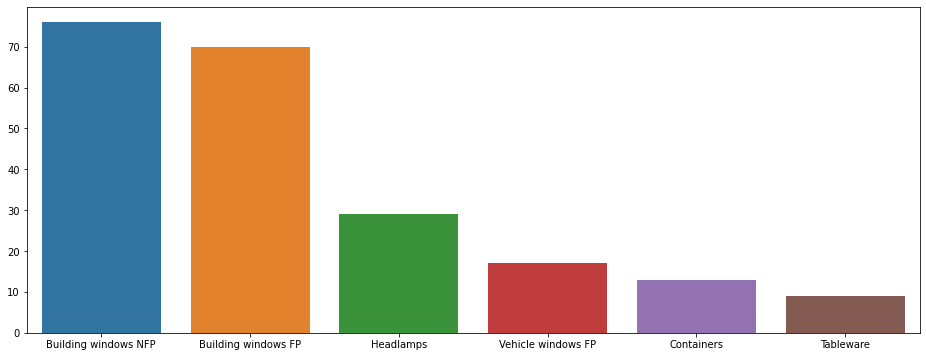

In [28]:
df_class_counts = df[class_column_name].value_counts()
plt.figure(figsize=(16, 6))
sns.barplot(df_class_counts.index, df_class_counts.values)

In [29]:
X, y = df[feature_names].to_numpy(), df['y'].to_numpy()
X = OneHotEncoder().fit_transform(X)

model_mnb = MultinomialNB()

sk_fold = StratifiedKFold(n_splits=8, random_state=3, shuffle=True)
cv_dict = cross_validate(model_mnb, X, y, cv=sk_fold, scoring='f1_macro')
print('avg f1:', cv_dict['test_score'].mean())

avg f1: 0.7002961459674594
